In [37]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous\\research'

In [3]:
os.chdir("../")
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous'

In [4]:
# load data
tickers_df = pd.read_parquet('artifacts/data_ingestion/tickers_df.parquet')
tickers_df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Ticker,Year,Month,Weekday,Date
0,0.840094,0.999442,1.004464,0.907924,0.936384,535796800,AAPL,2000,1,0,2000-01-03
1,0.769266,0.915179,0.987723,0.903460,0.966518,512377600,AAPL,2000,1,1,2000-01-04
2,0.780523,0.928571,0.987165,0.919643,0.926339,778321600,AAPL,2000,1,2,2000-01-05
3,0.712977,0.848214,0.955357,0.848214,0.947545,767972800,AAPL,2000,1,3,2000-01-06
4,0.746751,0.888393,0.901786,0.852679,0.861607,460734400,AAPL,2000,1,4,2000-01-07


In [31]:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-12-31')

# Filter for a date range
price_data_range = tickers_df[
    (tickers_df['Date'] >= start_date) & 
    (tickers_df['Date'] <= end_date)
]
# ticker_given_date = tickers_df[tickers_df['Date']==choose_date]

# ticker_given_date = ticker_given_date[['Date','Adj Close', 'Ticker']].reset_index(drop=True)
# ticker_given_date.head()

In [32]:
price_data = price_data_range.pivot(index='Date', columns='Ticker', values='Adj Close')
price_data.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,BAC,BRK-B,...,QCOM,TMO,TSLA,TXN,UNH,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,126.096573,86.739716,99.687317,238.710388,485.339996,92.300003,159.331497,38.326294,26.751953,228.449997,...,134.018921,466.015076,243.256668,141.991013,324.313202,210.421097,43.615047,26.608820,45.727539,34.215038
2021-01-05,127.655594,87.636650,100.920723,240.069397,485.690002,92.769997,160.925507,38.585880,26.956846,227.470001,...,137.565704,471.842407,245.036667,143.032578,319.951965,207.280609,43.414944,27.352432,45.484123,35.863964
2021-01-06,123.358521,86.879585,100.710594,242.694138,466.309998,90.330002,156.919006,38.347935,28.640545,230.270004,...,136.446594,479.240265,251.993332,143.741562,333.379150,205.454315,43.941135,29.287621,45.768105,36.779114
2021-01-07,127.567932,87.809433,101.688164,244.983932,477.739990,95.160004,158.108002,39.964016,29.273041,232.880005,...,140.516815,494.174164,272.013336,146.997681,338.724121,206.604187,43.842255,29.950609,45.764980,37.067673
2021-01-08,128.668991,88.270264,101.971420,245.877502,485.100006,94.580002,159.134995,40.166813,28.979057,234.029999,...,141.365128,505.997009,293.339996,149.816162,337.202271,208.188919,43.295460,29.735588,45.758743,37.479900


<Axes: xlabel='Ticker', ylabel='Ticker'>

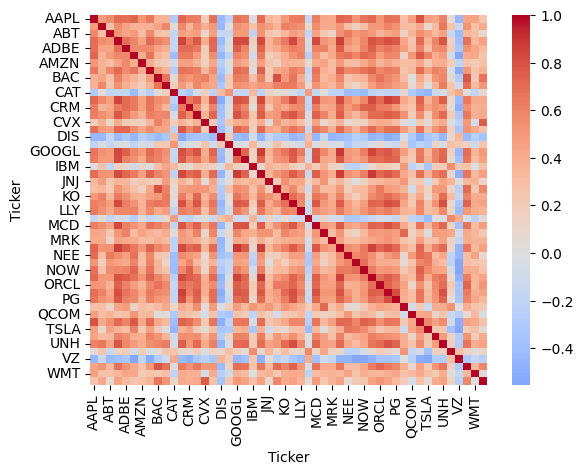

In [33]:
corr = price_data.corr(method='kendall')
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)

In [13]:
from scipy import optimize, stats


def bw_scott(data: np.ndarray):
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 3.49 * std_dev * n ** (-0.333)

def bw_silverman(data: np.ndarray):
    def _select_sigma(x):
        normalizer = 1.349
        iqr = (stats.scoreatpercentile(x, 75) - stats.scoreatpercentile(x, 25)) / normalizer
        std_dev = np.std(x, axis=0, ddof=1)
        return np.minimum(std_dev, iqr) if iqr > 0 else std_dev
    sigma = _select_sigma(data)
    n = len(data)
    return 0.9 * sigma * n ** (-0.2)

def bw_mlcv(data: np.ndarray, k):
    """
    Ref: https://rdrr.io/cran/kedd/src/R/MLCV.R
    """
    n = len(data)
    x = np.linspace(np.min(data), np.max(data), n)
    def mlcv(h):
        fj = np.zeros(n)
        for j in range(n):
            for i in range(n):
                if i == j: continue
                fj[j] += k((x[j] - data[i]) / h)
            fj[j] /= (n - 1) * h
        return -np.mean(np.log(fj[fj > 0]))
    h = optimize.minimize(mlcv, 1)
    if np.abs(h.x[0]) > 10:
        return bw_scott(data)
    return h.x[0]


In [4]:
def kernel(k: str):
    """Kernel function

    Args:
        k (str): kernel name: ['gaussian', 'epanechnikov']
    """
    if k not in ['gaussian', 'epanechnikov']:
        raise ValueError('Unknown kernel')
    
    def bounded(f): # decorator
        def _f(x):  # wrapper function
            return f(x) if np.abs(x) <= 1 else 0
        return _f
    
    if k == 'gaussian':
        return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)
    elif k == 'epanechnikov':
        return bounded(lambda u: (3 / 4 * (1 - u * u)))

In [19]:
def kernel_weights(t, s, h, S, k=None):
    if k is None:
        k = kernel('epanechnikov')
    wh = k((t - s)/(S*h))
    return wh/(S*h)

In [35]:
# calculate tau for a given t
def kendall_tau_estimator(Y_A, Y_B, h=None):
    assert len(Y_A) == len(Y_B), "Length Y_A and Y_B must be same"
    if h is None:
        h = 0.1
        print(h)
    S = len(Y_A) # both Y_A and Y_B needs to be of equal length
    tau_estimates = []
    # Create kernel function
    k = kernel('epanechnikov')
    for t in range(1,S+1):
        # weights = np.array([k((t - s) / (S * h)) / (S * h) for s in range(1, S + 1)])
        weights = np.array([kernel_weights(t, s, h, S) for s in range(1, S+1)])
        normalize = 1 - np.sum(weights**2)
        if normalize <=0:
            raise ValueError("Normalization is less than 0, Adjust 'h'")
        summed_weights = 0
        for s_idx, s in enumerate(range(1, S + 1)):
            for r_idx, r in enumerate(range(1, S + 1)):
                # Indicator function: I[{Y_A(s) < Y_A(r), Y_B(s) < Y_B(r)}]
                # Using 0-indexing for arrays
                indicator = int((Y_A[s_idx] < Y_A[r_idx]) and (Y_B[s_idx] < Y_B[r_idx]))
                
                summed_weights += weights[s_idx] * weights[r_idx] * indicator
        tau_t = (4/normalize )*summed_weights-1
        tau_estimates.append(tau_t)
    return tau_estimates

Tau estimate at t=10 is 0.954773343999854
Tau estimate at t=50 is 0.954773343999854
Tau estimate at t=90 is 0.954773343999854


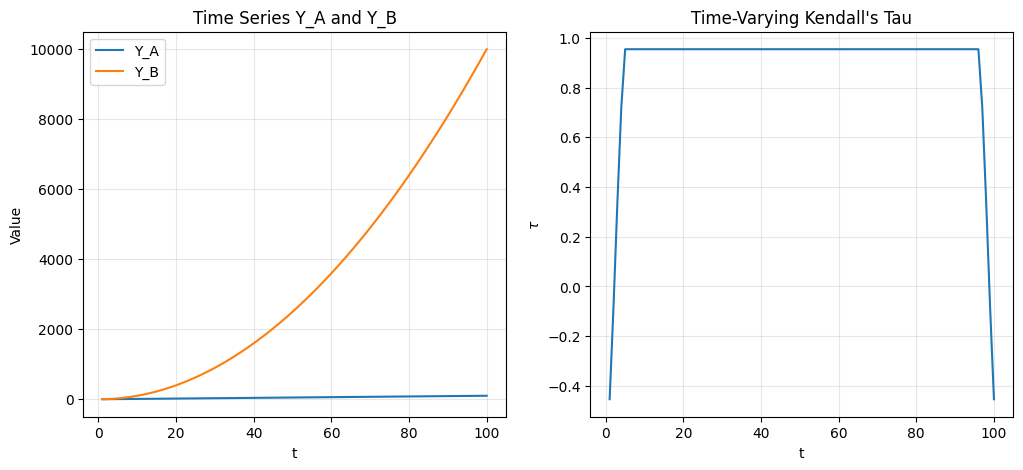

In [52]:
# test 1
Y_A = np.arange(1, 101)
Y_B = np.power(Y_A, 2)
# Y_B = np.arange(100, 199)
S = 100
t = np.arange(1, S+1)
tau_estimate = kendall_tau_estimator(Y_A, Y_B, h=0.05)
for time_point in [10, 50, 90,]:
    print(f"Tau estimate at t={time_point} is {tau_estimate[time_point]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(t, Y_A, label='Y_A')
ax1.plot(t, Y_B, label='Y_B')
ax1.set_xlabel('t')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)
ax1.set_title('Time Series Y_A and Y_B')
ax1.legend()

ax2.plot(t, tau_estimate)
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\tau$')
ax2.set_title("Time-Varying Kendall's Tau")
ax2.grid(True, alpha=0.3)